In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [62]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees, create_combined_df, create_combined_over_embeddings, _get_files, average_node_degree
sns.set()

In [13]:
embedding_approaches = ["BootEA","MultiKE","RDGCN"]
dataset_name = "D_W_15K_V1"
type_files = sorted([i for i in glob.iglob(f"../../data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [4]:
combined = create_combined_over_embeddings(embedding_approaches, dataset_name, type_files,"../../data/")

Create combined df: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


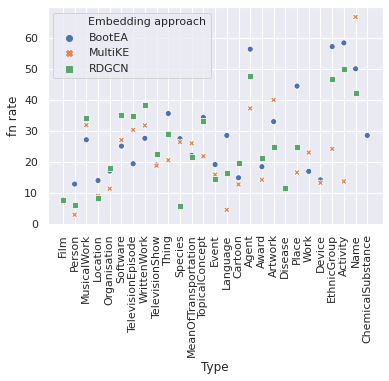

In [57]:
g = sns.scatterplot(x="Type",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

In [60]:
bootea = combined[combined["Embedding approach"]=="BootEA"]
rdgcn = combined[combined["Embedding approach"]=="RDGCN"]
multike = combined[combined["Embedding approach"]=="MultiKE"]

In [84]:
stats.kendalltau(bootea[bootea["fp rate"].notna()]["fp rate"], bootea[bootea["fp rate"].notna()]["rate of all"])

KendalltauResult(correlation=-0.7333333333333333, pvalue=0.05555555555555555)

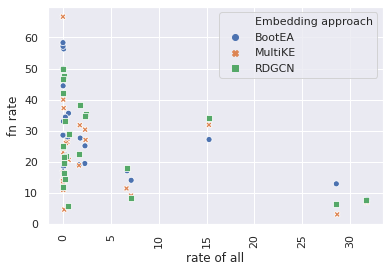

In [77]:
g = sns.scatterplot(x="rate of all",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)